# Import needed modules

In [ ]:
!pip install tensorflow==2.9.1

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Create needed functions

## Functions to Create Data Frame from Dataset

#### **Function to create data frame**

In [ ]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(train_dir, test_dir):
    # train and valid dataframe
    files, classes = define_paths(train_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # test dataframe
    files, classes = define_paths(test_dir)
    test_df = define_df(files, classes)

    return train_df, valid_df, test_df

#### Function to generate images from dataframe

In [ ]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

#### **Function to display data sample**

In [ ]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Callbacks**
<br>
Callbacks : Helpful functions to help optimize model training  <br>
Examples: stop model training after specfic time, stop training if no improve in accuracy and so on.

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

#### **Function to plot history of training**

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


#### **Function to create Confusion Matrix**

In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# **Model Structure**

#### **Start Reading Dataset**

In [ ]:
train_dir = 'drive/MyDrive/dataset/train'
test_dir = 'drive/MyDrive/dataset/test'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(train_dir, test_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 2109 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
Found 660 validated image filenames belonging to 2 classes.


#### **Display Image Sample**

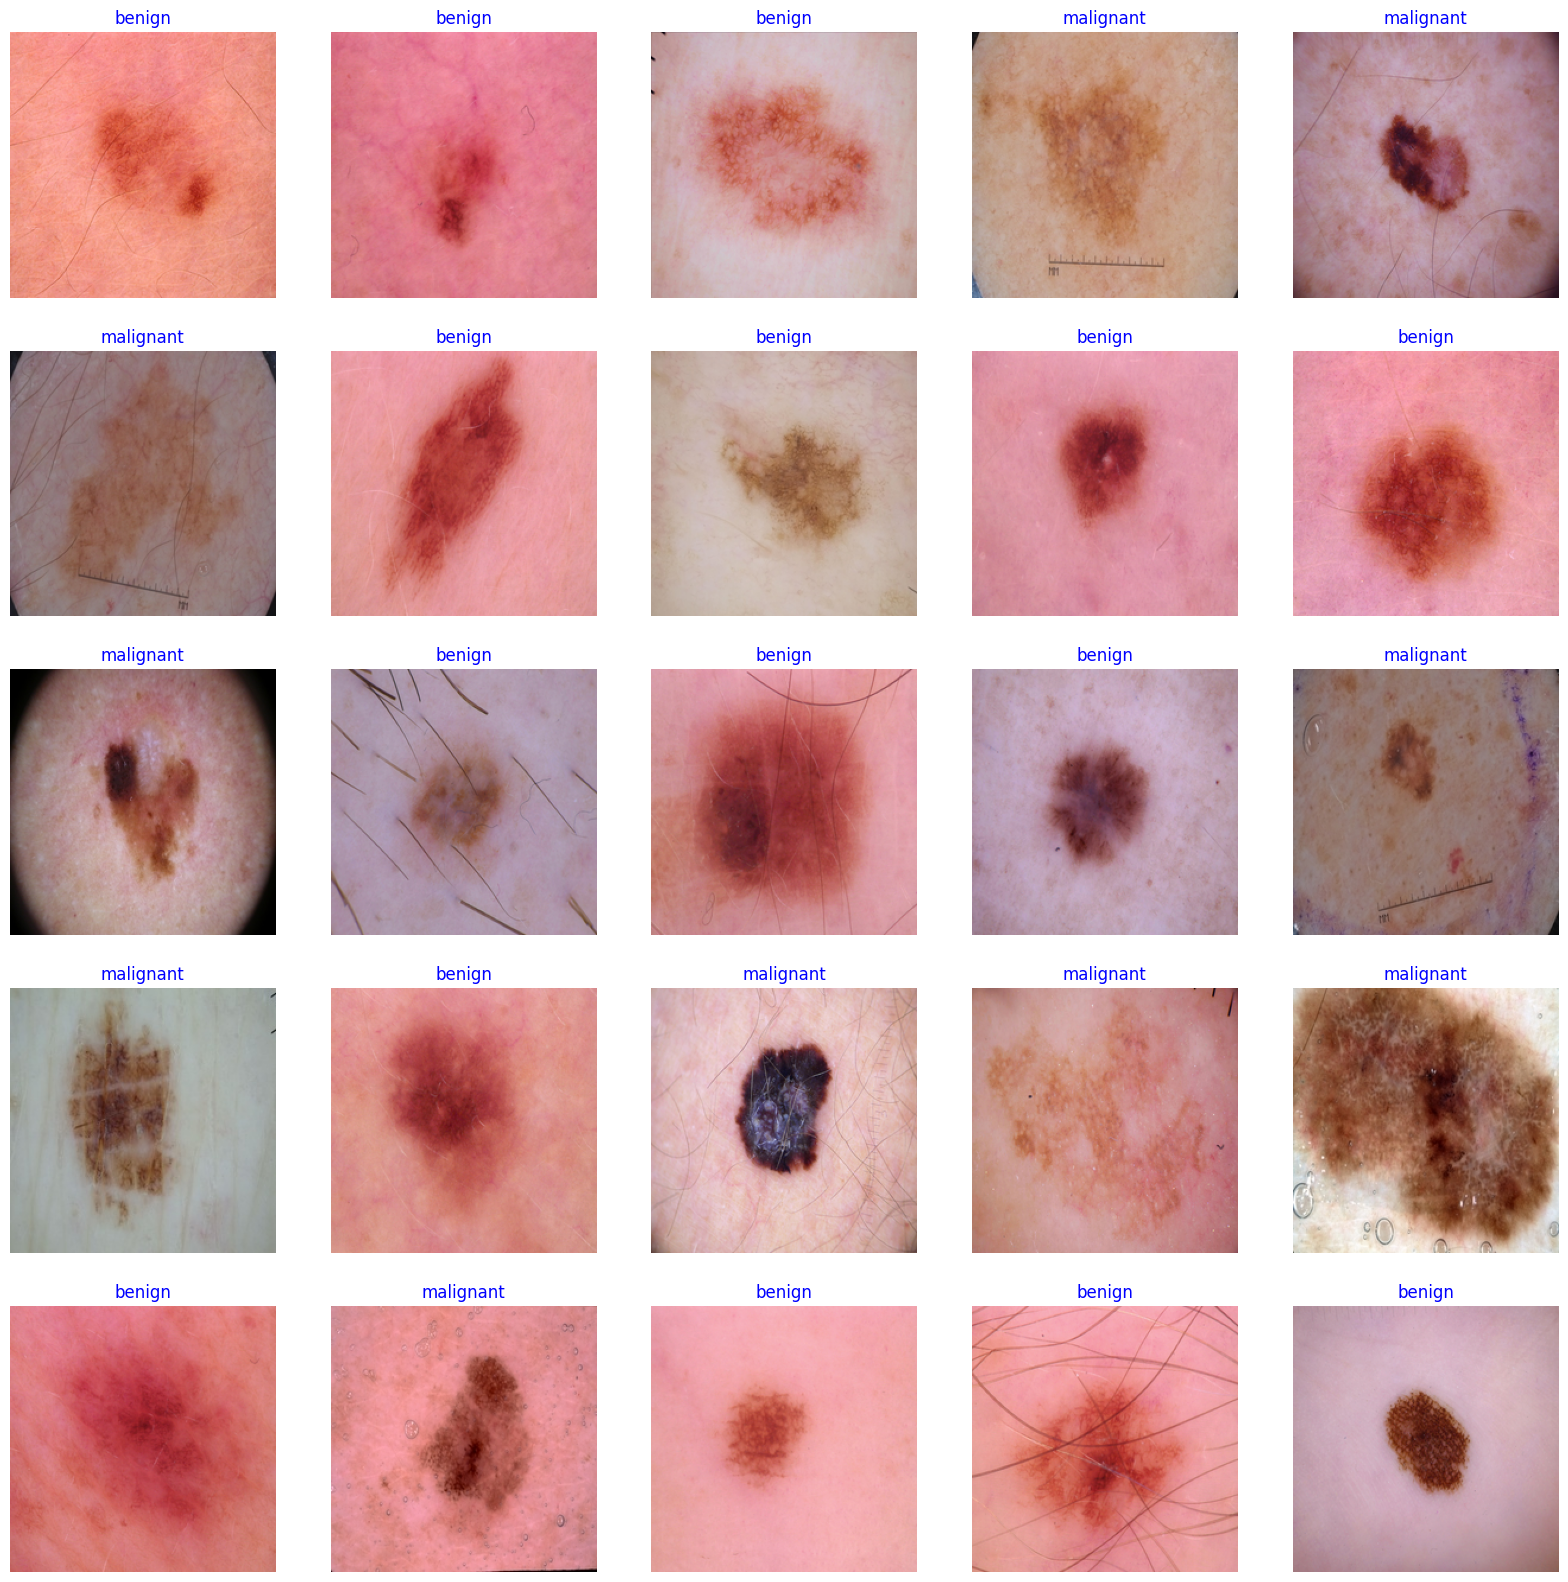

In [ ]:
show_images(train_gen)

#### **Generic Model Creation**

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy','AUC', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                           

#### **Set Callback Parameters**

In [ ]:
batch_size = 40   # set batch size for training
epochs = 100   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 40  # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("drive/MyDrive/mobilenet_best_epoch/", save_best_only=True)
callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch ), checkpoint_cb]

#### **Train model**

In [ ]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?
n
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /100    7.034   78.900   9.53240  45.455   0.00100  0.00100  accuracy     0.00    704.34 


 2 /100    5.131   87.055   5.68458  60.606   0.00100  0.00100  accuracy    10.34    16.56  


 3 /100    4.029   91.275   4.62657  59.848   0.00100  0.00100  val_loss    18.61    16.05  


 4 /100    3.245   92.793   4.03225  55.114   0.00100  0.00100  val_loss    12.85    15.96  


 5 /100    2.640   94.784   3.10324  71.402   0.00100  0.00100  val_loss    23.04    16.95  


 6 /100    2.169   96.539   2.82025  63.258   0.00100  0.00100  val_loss     9.12    16.14  


 7 /100    1.789   97.534   2.31266  74.432   0.00100  0.00100  val_loss    18.00    16.31  


 8 /100    1.487   98.198   2.13229  74.053   0.00100  0.00100  val_loss     7.80    16.22  


 9 /100    1.246   98.530   1.86985  75.568   0.00100  0.00100  val_loss    12.31    16.31  


10 /100    1.039   99.147   1.73045  74.242   0.00100  0.00100  val_loss     7.45    16.13  


11 /100    0.877   99.004   1.50902  78.409   0.00100  0.00100  val_loss    12.80    16.23  


12 /100    0.736   99.431   1.57998  75.000   0.00100  0.00050  val_loss    -4.70    16.60  
13 /100    0.633   99.810   1.53191  74.053   0.00050  0.00025  val_loss    -1.52    16.44  
14 /100    0.592   99.858   1.47306  74.432   0.00025  0.00025  val_loss     2.38    17.61  


15 /100    0.568   99.763   1.41930  75.379   0.00025  0.00025  val_loss     3.65    15.78  


16 /100    0.540   99.905   1.30566  77.083   0.00025  0.00025  val_loss     8.01    16.48  


17 /100    0.514   99.905   1.23455  77.273   0.00025  0.00025  val_loss     5.45    16.45  


18 /100    0.493   99.810   1.09221  79.167   0.00025  0.00025  val_loss    11.53    16.24  


19 /100    0.465   99.810   0.96361  80.682   0.00025  0.00025  val_loss    11.77    16.10  


20 /100    0.442   99.953   0.91092  80.114   0.00025  0.00025  val_loss     5.47    16.13  


21 /100    0.420   99.858   0.87898  80.492   0.00025  0.00025  val_loss     3.51    16.37  


22 /100    0.397   99.810   0.77667  82.576   0.00025  0.00025  val_loss    11.64    16.64  


23 /100    0.377   99.905   0.74375  83.523   0.00025  0.00025  val_loss     4.24    16.06  


24 /100    0.358   99.810   0.66907  85.417   0.00025  0.00025  val_loss    10.04    16.79  


25 /100    0.333   99.905   0.65422  84.659   0.00025  0.00025  val_loss     2.22    16.09  


26 /100    0.318   99.858   0.64257  83.902   0.00025  0.00025  val_loss     1.78    16.66  


27 /100    0.298   99.905   0.65115  83.902   0.00025  0.00013  val_loss    -1.34    16.83  
28 /100    0.286   99.953   0.58987  85.227   0.00013  0.00013  val_loss     8.20    16.19  


29 /100    0.282   99.810   0.58995  85.227   0.00013  0.00006  val_loss    -0.01    16.38  
30 /100    0.276   99.953   0.57035  85.985   0.00006  0.00006  val_loss     3.31    15.97  


31 /100    0.267   100.000  0.54865  86.364   0.00006  0.00006  val_loss     3.80    16.00  


32 /100    0.264   99.905   0.54199  86.174   0.00006  0.00006  val_loss     1.21    15.83  


33 /100    0.260   99.953   0.54347  86.364   0.00006  0.00003  val_loss    -0.27    15.85  
34 /100    0.257   100.000  0.53481  86.932   0.00003  0.00003  val_loss     1.33    15.79  


35 /100    0.253   100.000  0.52619  87.500   0.00003  0.00003  val_loss     1.61    15.86  


36 /100    0.250   100.000  0.51604  87.879   0.00003  0.00003  val_loss     1.93    16.38  


37 /100    0.252   99.763   0.49930  89.015   0.00003  0.00003  val_loss     3.24    15.97  


38 /100    0.250   99.953   0.50200  88.447   0.00003  0.00002  val_loss    -0.54    15.61  
39 /100    0.247   99.953   0.49978  89.015   0.00002  0.00001  val_loss    -0.10    15.76  
40 /100    0.248   99.953   0.49585  88.826   0.00001  0.00001  val_loss     0.69    15.88  


41 /100    0.245   100.000  0.49533  89.205   0.00001  0.00001  val_loss     0.11    15.77  


42 /100    0.246   99.858   0.49257  89.205   0.00001  0.00001  val_loss     0.56    15.75  


43 /100    0.242   100.000  0.49092  89.394   0.00001  0.00001  val_loss     0.34    16.83  


44 /100    0.243   99.905   0.49118  88.826   0.00001  0.00000  val_loss    -0.05    15.99  
45 /100    0.246   100.000  0.49021  89.015   0.00000  0.00000  val_loss     0.14    16.15  


46 /100    0.242   100.000  0.49017  89.015   0.00000  0.00000  val_loss     0.01    15.91  


47 /100    0.244   99.858   0.48966  89.015   0.00000  0.00000  val_loss     0.10    16.43  


48 /100    0.240   100.000  0.48826  89.015   0.00000  0.00000  val_loss     0.29    16.08  


49 /100    0.240   100.000  0.48640  89.015   0.00000  0.00000  val_loss     0.38    15.98  


50 /100    0.243   100.000  0.48511  88.826   0.00000  0.00000  val_loss     0.26    15.46  


51 /100    0.243   99.953   0.48305  89.015   0.00000  0.00000  val_loss     0.42    15.99  


52 /100    0.238   100.000  0.48074  89.205   0.00000  0.00000  val_loss     0.48    16.05  


53 /100    0.240   99.953   0.48025  89.394   0.00000  0.00000  val_loss     0.10    15.82  


54 /100    0.242   99.858   0.47964  89.394   0.00000  0.00000  val_loss     0.13    17.28  


55 /100    0.236   100.000  0.47903  89.205   0.00000  0.00000  val_loss     0.13    15.73  


56 /100    0.237   100.000  0.47802  89.205   0.00000  0.00000  val_loss     0.21    15.77  


57 /100    0.238   99.953   0.47771  89.394   0.00000  0.00000  val_loss     0.07    15.99  


58 /100    0.238   100.000  0.47724  89.394   0.00000  0.00000  val_loss     0.10    16.08  


59 /100    0.238   100.000  0.47674  89.205   0.00000  0.00000  val_loss     0.10    15.68  


60 /100    0.239   99.953   0.47639  89.015   0.00000  0.00000  val_loss     0.07    15.73  


61 /100    0.238   99.953   0.47619  89.015   0.00000  0.00000  val_loss     0.04    16.84  


62 /100    0.236   100.000  0.47566  89.205   0.00000  0.00000  val_loss     0.11    15.70  


63 /100    0.237   99.953   0.47669  89.015   0.00000  0.00000  val_loss    -0.22    15.86  
64 /100    0.237   100.000  0.47675  89.015   0.00000  0.00000  val_loss    -0.23    15.77  
65 /100    0.239   99.905   0.47685  89.205   0.00000  0.00000  val_loss    -0.25    15.52  
66 /100    0.237   100.000  0.47671  89.205   0.00000  0.00000  val_loss    -0.22    17.38  
67 /100    0.236   100.000  0.47691  89.205   0.00000  0.00000  val_loss    -0.26    16.30  
68 /100    0.239   99.858   0.47676  89.205   0.00000  0.00000  val_loss    -0.23    15.83  
69 /100    0.239   99.953   0.47649  89.205   0.00000  0.00000  val_loss    -0.18    16.03  
70 /100    0.236   100.000  0.47636  89.205   0.00000  0.00000  val_loss    -0.15    16.16  
71 /100    0.236   100.000  0.47618  89.205   0.00000  0.00000  val_loss    -0.11    15.93  
72 /100    0.235   100.000  0.47625  89.015   0.00000  0.00000  val_loss    -0.13    15.87  
73 /100    0.236   100.000  0.47629  89.205   0.00000  0.00000  val_lo

#### **Display model performance**

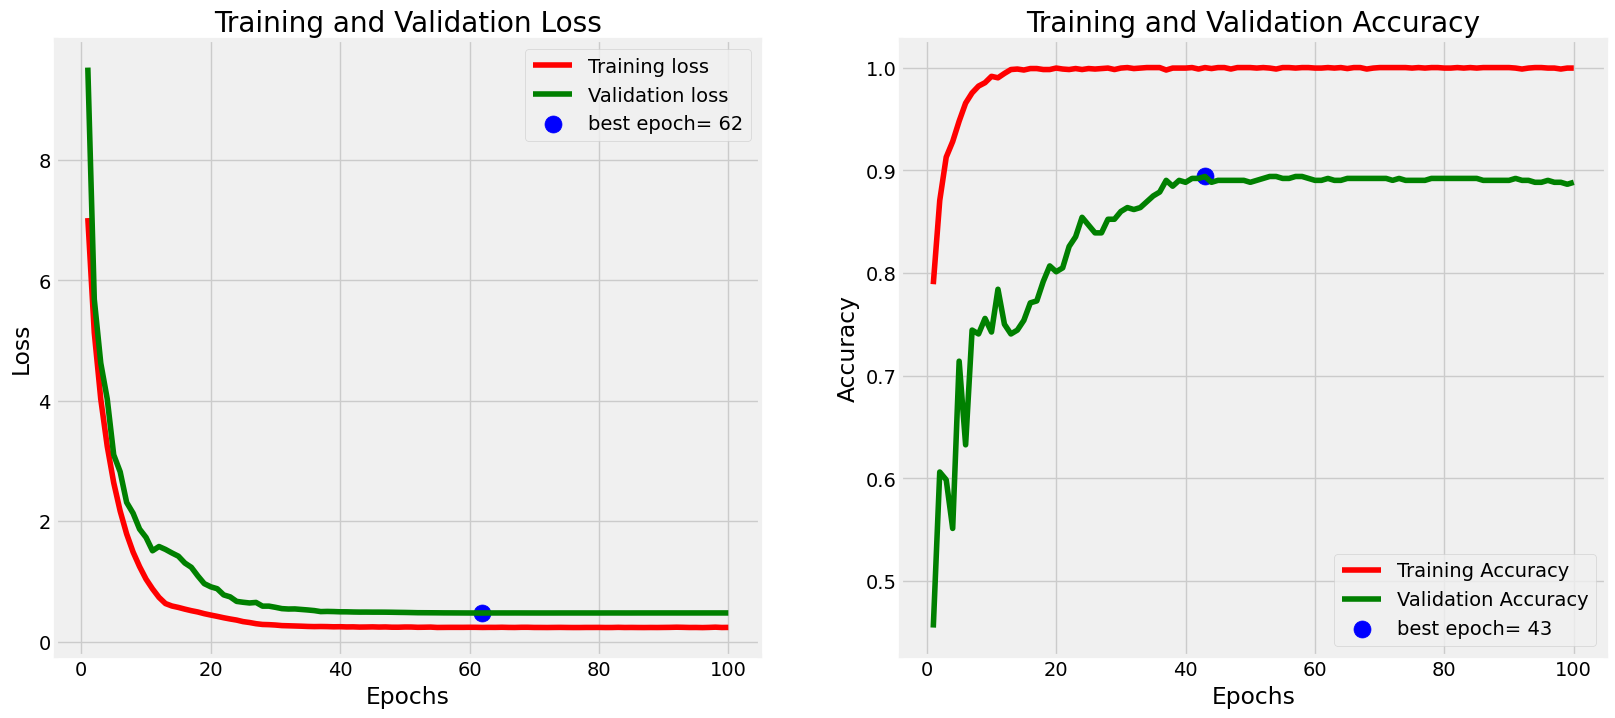

In [ ]:
plot_training(history)

# **Evaluate model**

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/10 [==============================] - 431s 48s/step - loss: 0.4681 - accuracy: 0.9015 - auc: 0.9604 - precision: 0.9015 - recall: 0.9015
Train Loss:  0.22328068315982819
Train Accuracy:  1.0
--------------------
Validation Loss:  0.4831337630748749
Validation Accuracy:  0.8899999856948853
--------------------
Test Loss:  0.46806520223617554
Test Accuracy:  0.9015151262283325


# **Get Predictions**

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 1
 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1
 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0
 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

#### **Confusion Matrics and Classification Report**

Confusion Matrix, Without Normalization
[[337  23]
 [ 42 258]]
              precision    recall  f1-score   support

      benign       0.89      0.94      0.91       360
   malignant       0.92      0.86      0.89       300

    accuracy                           0.90       660
   macro avg       0.90      0.90      0.90       660
weighted avg       0.90      0.90      0.90       660



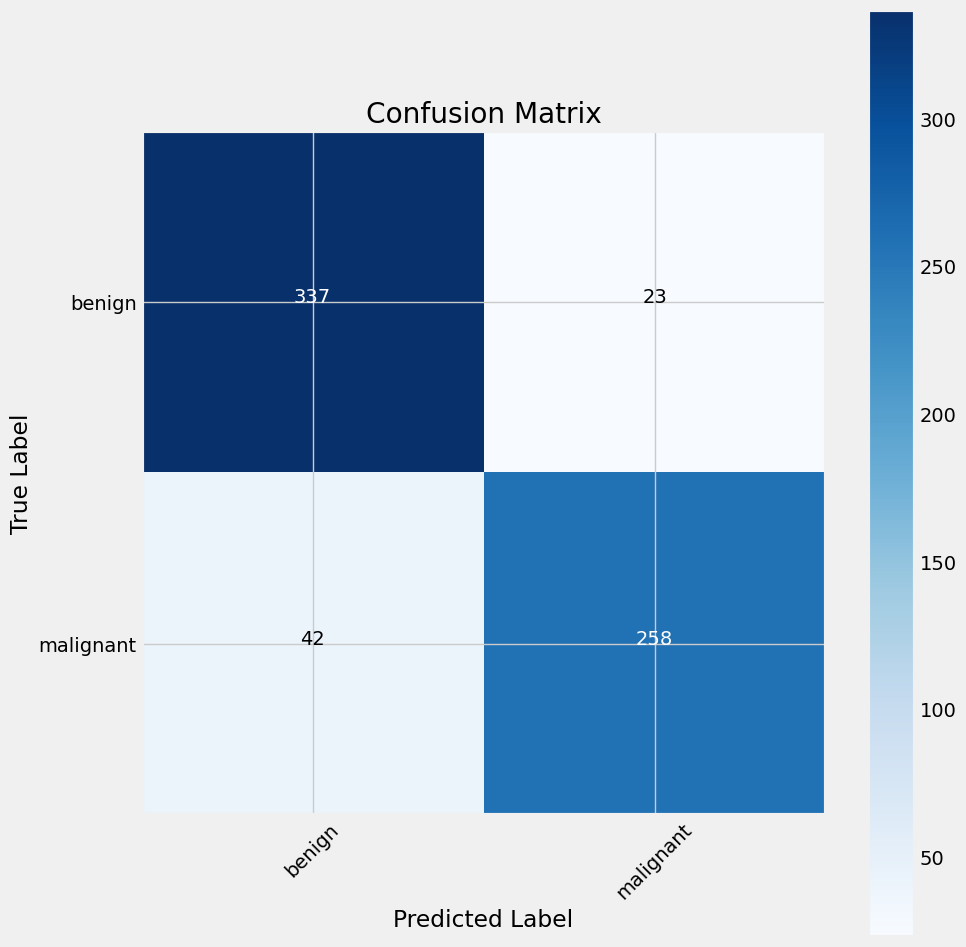

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [ ]:
trained_model = tf.keras.models.load_model('drive/MyDrive/mobilenet_best_epoch')

drive/MyDrive/dataset/test/benign/624.jpg
1/1 [==============================] - 1s 1s/step
[0.0795297  0.92047024]
drive/MyDrive/dataset/test/benign/88.jpg
1/1 [==============================] - 0s 26ms/step
[0.6119647  0.38803533]
drive/MyDrive/dataset/test/malignant/1256.jpg
1/1 [==============================] - 0s 29ms/step
[0.01992444 0.9800756 ]
drive/MyDrive/dataset/test/benign/1737.jpg
1/1 [==============================] - 0s 24ms/step
[0.12771678 0.8722832 ]
drive/MyDrive/dataset/test/benign/1393.jpg
1/1 [==============================] - 0s 25ms/step
[0.4669248 0.5330752]
drive/MyDrive/dataset/test/benign/367.jpg
1/1 [==============================] - 0s 25ms/step
[0.93952405 0.06047592]
drive/MyDrive/dataset/test/benign/16.jpg
1/1 [==============================] - 0s 27ms/step
[0.9866356  0.01336435]
drive/MyDrive/dataset/test/malignant/62.jpg
1/1 [==============================] - 0s 25ms/step
[0.04880303 0.95119697]
drive/MyDrive/dataset/test/malignant/437.jpg
1/1 [====

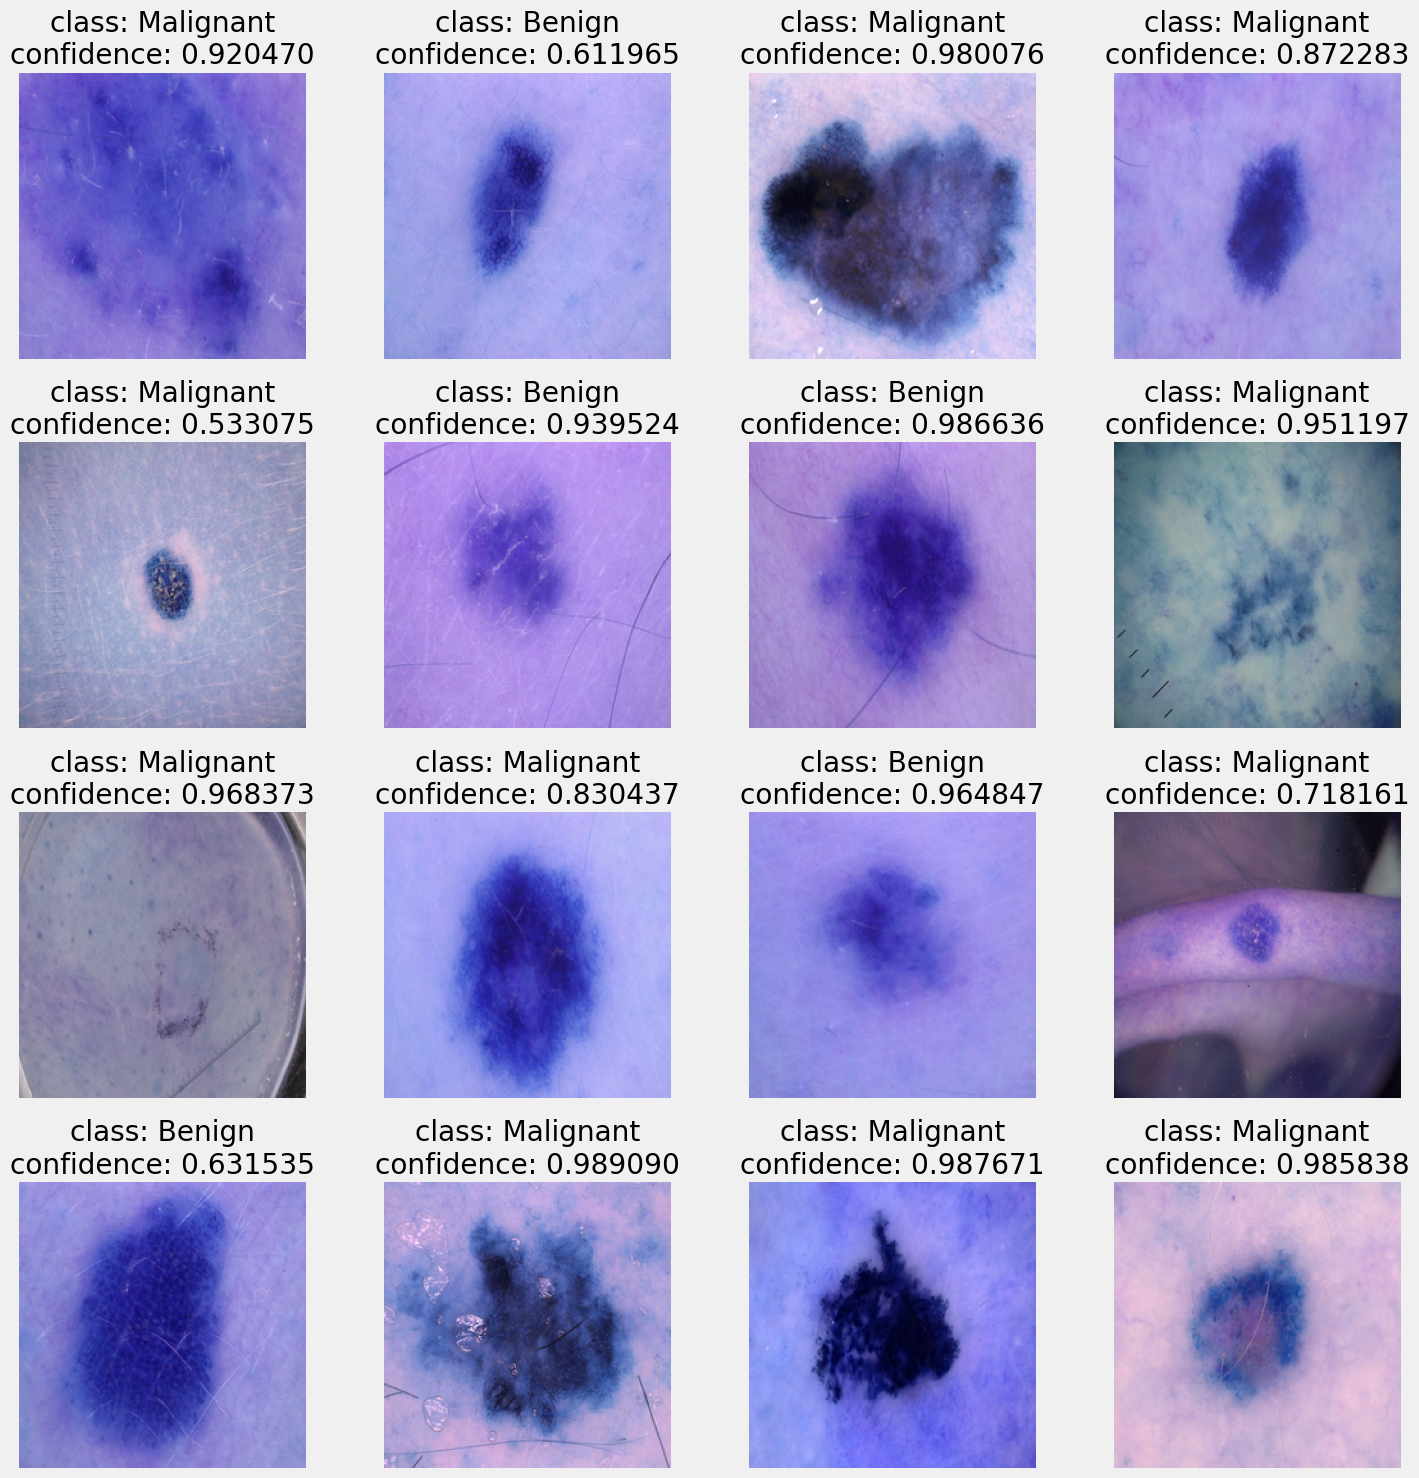

In [ ]:
import random

Labels = ["Benign", "Malignant"]

def upload(filename):
    print(filename)
    img = cv2.imread(os.path.join(filename))
    img = cv2.resize(img, (224, 224))
    return img

def pre_result(img):
    x = trained_model.predict(np.asarray([img]))[0]
    print(x)
    classx = np.argmax(x)
    return {Labels[classx]: x[classx]}

images = random.sample(test_gen.filenames, 16)

fig = plt.figure(figsize=(15,15))

for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)


    # Add the image to the grid
    ax = fig.add_subplot(4, 4, idx+1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("class: %s\nconfidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))

plt.tight_layout()
plt.show()


In [ ]:
import json

file_path = 'drive/MyDrive/mobilenet_history.json'
# Save the history data to a file
with open(file_path, 'w') as f:
    json.dump(history.history, f)

In [ ]:
# Make predictions on the validation data
y_pred = trained_model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)

# Calculate the F1 score
f1 = f1_score(test_gen.labels, y_pred, average='weighted')

print(f'F1-score: {f1:.2f}')

10/10 [==============================] - 4s 265ms/step
F1-score: 0.90


In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.head(30)

loss  accuracy       auc  precision    recall  val_loss  val_accuracy  \
0   7.033669  0.788999  0.872410   0.788999  0.788999  9.532405      0.454545   
1   5.131117  0.870555  0.947924   0.870555  0.870555  5.684575      0.606061   
2   4.028717  0.912755  0.969985   0.912755  0.912755  4.626575      0.598485   
3   3.245442  0.927928  0.979767   0.927928  0.927928  4.032249      0.551136   
4   2.640493  0.947843  0.989266   0.947843  0.947843  3.103240      0.714015   
5   2.168781  0.965386  0.994618   0.965386  0.965386  2.820248      0.632576   
6   1.789012  0.975344  0.997474   0.975344  0.975344  2.312657      0.744318   
7   1.487401  0.981982  0.998312   0.981982  0.981982  2.132292      0.740530   
8   1.246372  0.985301  0.998591   0.985301  0.985301  1.869846      0.755682   
9   1.038556  0.991465  0.999654   0.991465  0.991465  1.730452      0.742424   
10  0.876731  0.990043  0.999366   0.990043  0.990043  1.509020      0.784091   
11  0.735564  0.994310  0.999889   0.994310  0.994310  1.579977      0.750000   
12  0.633043  0.998103  0.999991   0.998103  0.998103  1.531914      0.740530   
13  0.592146  0.998578  0.999993   0.998578  0.998578  1.473062      0.744318   
14  0.568348  0.997629  0.999984   0.997629  0.997629  1.419299      0.753788   
15  0.539976  0.999052  0.999998   0.999052  0.999052  1.305660      0.770833   
16  0.514387  0.999052  0.999967   0.999052  0.999052  1.234549      0.772727   
17  0.492867  0.998103  0.999804   0.998103  0.998103  1.092208      0.791667   
18  0.464809  0.998103  0.999992   0.998103  0.998103  0.963606      0.806818   
19  0.441789  0.999526  0.999999   0.999526  0.999526  0.910915      0.801136   
20  0.420356  0.998578  0.999892   0.998578  0.998578  0.878981      0.804924   
21  0.396961  0.998103  0.999985   0.998103  0.998103  0.776675      0.825758   
22  0.376533  0.999052  0.999999   0.999052  0.999052  0.743753      0.835227   
23  0.358331  0.998103  0.999946   0.998103  0.998103  0.669072      0.854167   
24  0.333005  0.999052  0.999941   0.999052  0.999052  0.654218      0.846591   
25  0.317922  0.998578  0.999992   0.998578  0.998578  0.642566      0.839015   
26  0.298427  0.999052  0.999984   0.999052  0.999052  0.651152      0.839015   
27  0.285823  0.999526  0.999999   0.999526  0.999526  0.589869      0.852273   
28  0.282351  0.998103  0.999984   0.998103  0.998103  0.589954      0.852273   
29  0.276098  0.999526  0.999997   0.999526  0.999526  0.570349      0.859848   

     val_auc  val_precision  val_recall  
0   0.472387       0.454545    0.454545  
1   0.644329       0.606061    0.606061  
2   0.660323       0.598485    0.598485  
3   0.630111       0.551136    0.551136  
4   0.791927       0.714015    0.714015  
5   0.707472       0.632576    0.632576  
6   0.819993       0.744318    0.744318  
7   0.792655       0.740530    0.740530  
8   0.818598       0.755682    0.755682  
9   0.808674       0.742424    0.742424  
10  0.845427       0.784091    0.784091  
11  0.785960       0.750000    0.750000  
12  0.796825       0.740530    0.740530  
13  0.810312       0.744318    0.744318  
14  0.822049       0.753788    0.753788  
15  0.839254       0.770833    0.770833  
16  0.839614       0.772727    0.772727  
17  0.862677       0.791667    0.791667  
18  0.878883       0.806818    0.806818  
19  0.877750       0.801136    0.801136  
20  0.882974       0.804924    0.804924  
21  0.901718       0.825758    0.825758  
22  0.906523       0.835227    0.835227  
23  0.919230       0.854167    0.854167  
24  0.918650       0.846591    0.846591  
25  0.915974       0.839015    0.839015  
26  0.906544       0.839015    0.839015  
27  0.925085       0.852273    0.852273  
28  0.922930       0.852273    0.852273  
29  0.928192       0.859848    0.859848

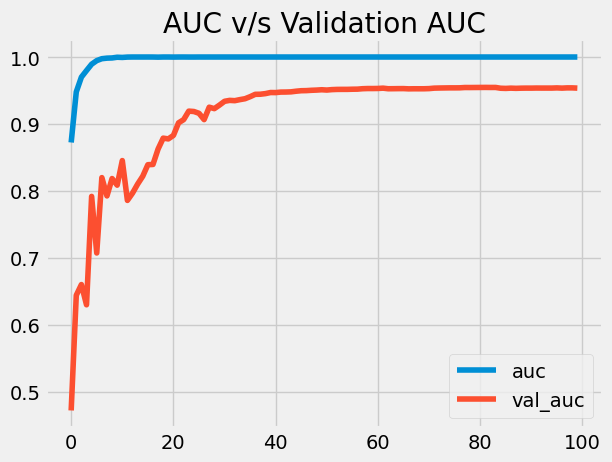

In [ ]:
hist_df['auc'].plot()
hist_df['val_auc'].plot()
plt.title('AUC v/s Validation AUC')
plt.legend()
plt.show()

In [ ]:
test_gen.reset()  # resetting generator
y_pred = trained_model.predict(test_gen, verbose=1)

10/10 [==============================] - 3s 249ms/step


ROC AUC: 0.96



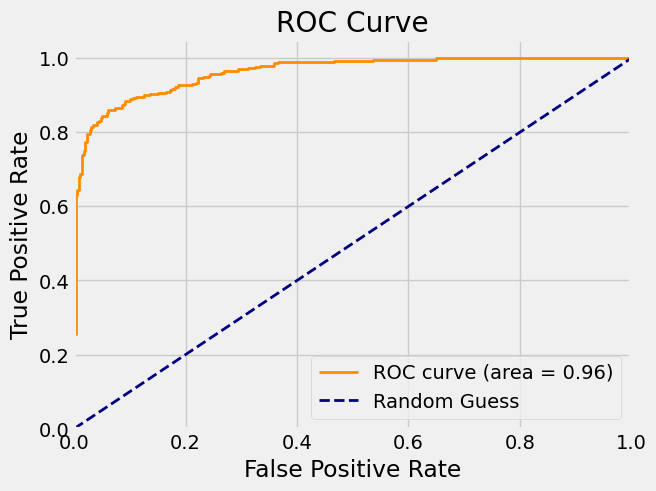

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = 2
for i in range(num_classes):
    y_pred_class_i = y_pred[:, i]
    fpr[i], tpr[i], _ = roc_curve(test_gen.labels, y_pred_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])


# print score
print('ROC AUC: %0.2f\n' % roc_auc[1])
plt.figure()
lw = 2  # Line width

plt.plot(fpr[1], tpr[1], color='darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, label='Random Guess', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Generate predictions for validation dataset
y_pred = trained_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

10/10 [==============================] - 2s 247ms/step


[[0.93611111 0.06388889]
 [0.14       0.86      ]]


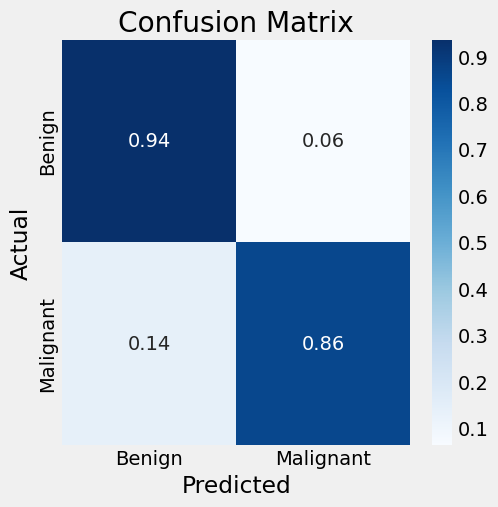

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn


# Create confusion matrix
cmn = confusion_matrix(test_gen.classes, y_pred_classes)
cmn = cmn.astype('float') / cmn.sum(axis=1)[:, np.newaxis]
print(cmn)
# Plot confusion matrix
plt.figure(figsize=(5, 5))
sn.heatmap(cmn, annot=True, cmap='Blues', fmt='.2f', xticklabels=Labels, yticklabels=Labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()